In [98]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp


## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")
print(mode_1_exp)
print(mode_2_exp)


1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
[1.         0.40133264 0.18596369 0.41904244 0.36876562 0.2982183
 0.37355081 1.        ]
[-0.68703015 -0.30749806 -0.16960222 -0.28307242  0.1658786   0.38510734
 -0.43796659  0.51252583]


In [2]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

Launch Pymapdl
     Launch Pymapdl successfully, duration 5.8727 seconds.


- fix parameter: all of the nu
- vary parameter: t, e, rho, vs, dr, height
- Assumption: x_slab = t_stair
- Number of parameter reduced to: 19

In [ ]:
from pyDOE import lhs
import numpy as np
import json

# Generate LHS data
num_samples = 1000  # Number of samples
num_parameters = 19  # Number of parameters

# Create LHS data in [0, 1] range
X_samples = lhs(num_parameters, samples=num_samples)

# Convert to a Python list for JSON compatibility
X_samples_list = X_samples.tolist()


# Save to a JSON file
#with open('lhs_data.json', 'w') as json_file:
#    json.dump(X_samples_list, json_file, indent=4)  # indent for better readability
#print("LHS data saved to 'lhs_data.json'")



LHS data saved to 'lhs_data.json'


In [3]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5
# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex220/"

# Transform X from [0,1] to [-1,1]
X_transformed = 2 * X - 1

# 154 - 159 usgin 18 modeal
# 
for i_doe in range(0,500):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    X_doe = X[i_doe,:]
    X_doe_transformed = X_transformed[i_doe,:]

    
    simu_tk.mapdl.clear()

    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                          0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                          0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                          0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    
    nu_para  = np.array([ 0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27])
    
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                          2300 + vary_ratio*2300*X_transformed[i_doe,11],
                          2300 + vary_ratio*2300*X_transformed[i_doe,12],
                          2300 + vary_ratio*2300*X_transformed[i_doe,13],
                          2300 + vary_ratio*2300*X_transformed[i_doe,14],
                          2300 + vary_ratio*2300*X_transformed[i_doe,10]])

    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                           1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                           0.33 ])
    
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]

    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()


    # Excitation point: Hammer 2.0 Pos1 (shaker)
    tol = 0.3
    #simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    #simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    #nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    #simu_tk.mapdl.nsel('ALL')


    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')

    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    #simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    #simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    #nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    #simu_tk.mapdl.nsel('ALL')

    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1.0, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    

    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)

 
    ## Get FRF at target point
    meas_FRFs = simu_tk.get_FRFs_meas_EXAMPLE()
  
    
    DOE_info = {
        'id':i_doe,
        'X':X_doe.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs
        }
    with open(full_path, "w") as file:
        json.dump(DOE_info, file, indent=4)  # `indent=4` for pretty printing
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.4965717099297
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated


KeyboardInterrupt: Interrupted during MAPDL execution

In [103]:
import os
import json
import numpy as np
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

# Load the JSON file
i_doe = 9
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.5 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
    #i_ch_disp_2 = [9,10,11,12]
    #for i_plot in i_ch_disp:
    #    plt.plot(loaded_data['meas_frf'][f'disp_ch{i_plot}']['freq'], loaded_data['meas_frf'][f'disp_ch{i_plot}']['imag'],linestyle=":")
    #plt.axvline(x=f_n_1_mean, color='red', linestyle='--', label=f'fn1:{f_n_1_mean}')
    #plt.axvline(x=f_n_2_mean, color='red', linestyle='--', label=f'fn2:{f_n_2_mean}')
    #plt.title(f'i_doe: {i_doe}')
    #plt.legend()
    #plt.show()

print(len(i_doe_valid))
valid_X = X[i_doe_valid]
valid_Y0 = MMI_1[i_doe_valid]
valid_Y1 = MMI_2[i_doe_valid]
valid_Y2 = Fn_values_1[i_doe_valid]
valid_Y3 = Fn_values_2[i_doe_valid]
valid_Y4 = MAC_values_1[i_doe_valid]
valid_Y5 = MAC_values_2[i_doe_valid]





499


### Using Random Forest Classifier extract the featrue importance

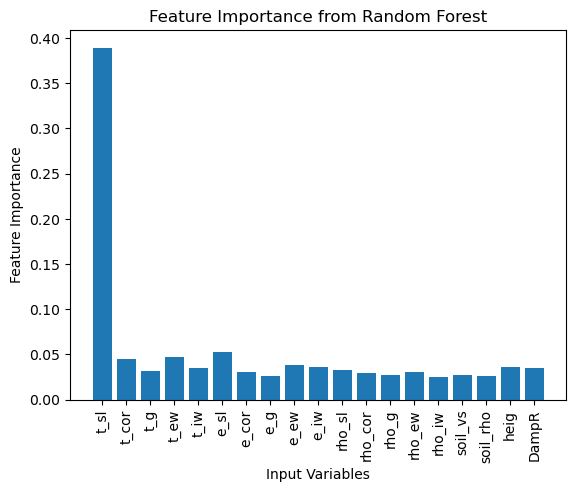

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84       158
         1.0       0.81      0.87      0.84       142

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
y = np.ones(1000)
y[i_doe_wrong] = 0

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importance
feature_importance = clf.feature_importances_

# Print or visualize feature importance

plt.bar(range(len(feature_importance)), feature_importance,tick_label = input_name)
plt.xlabel("Input Variables")
plt.ylabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.xticks(rotation=90)
plt.show()

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))







### Find the correlation using pearson and spearman method

(515, 24)


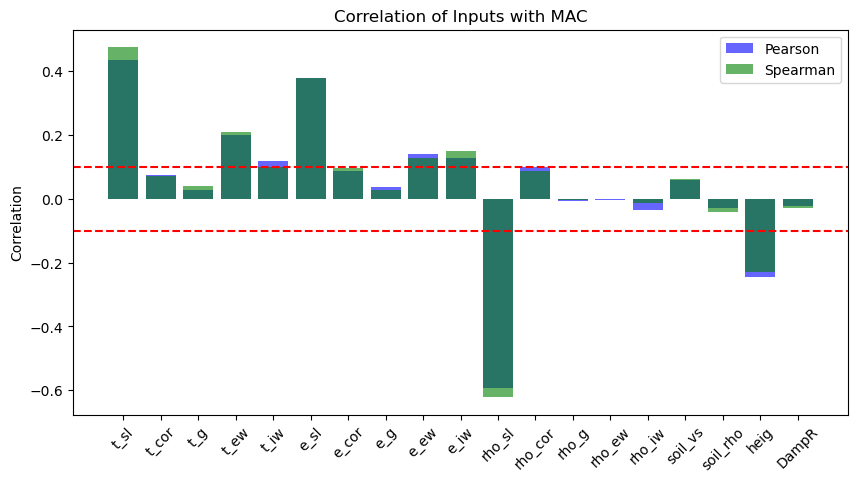

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


data_type = 'fn_2'


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2

data = data[data['MAC_1'] >= 0.4]
data = data[data['MAC_2'] >= 0.4]

print(np.shape(data))

# Compute Pearson correlation
pearson_corr = data.corr(method='pearson')[data_type][:-1]  # Exclude 'MAC' with itself

# Compute Spearman correlation
spearman_corr = data.corr(method='spearman')[data_type][:-1]  # Exclude 'MAC' with itself

sorted_pearson = pearson_corr.abs().sort_values(ascending=False)
sorted_spearman = spearman_corr.abs().sort_values(ascending=False)

#print("Top Inputs by Pearson Correlation:")
#print(sorted_pearson.head())

#print("Top Inputs by Spearman Correlation:")
#print(sorted_spearman.head())


# Plot correlations
plt.figure(figsize=(10, 5))
plt.bar(range(len(pearson_corr))[:19], pearson_corr[:19], label='Pearson', alpha=0.6, color='blue')
plt.bar(range(len(spearman_corr))[:19], spearman_corr[:19], label='Spearman', alpha=0.6, color='green')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=-0.1, color='red', linestyle='--')

plt.xticks(range(len(pearson_corr))[:19], pearson_corr.index[:19], rotation=45)
plt.ylabel('Correlation')
plt.title('Correlation of Inputs with MAC')
plt.legend()
plt.show()


### Visualization of correlation
- Only focus on the data that MAC 1 and MAC 2 larger than 0.4

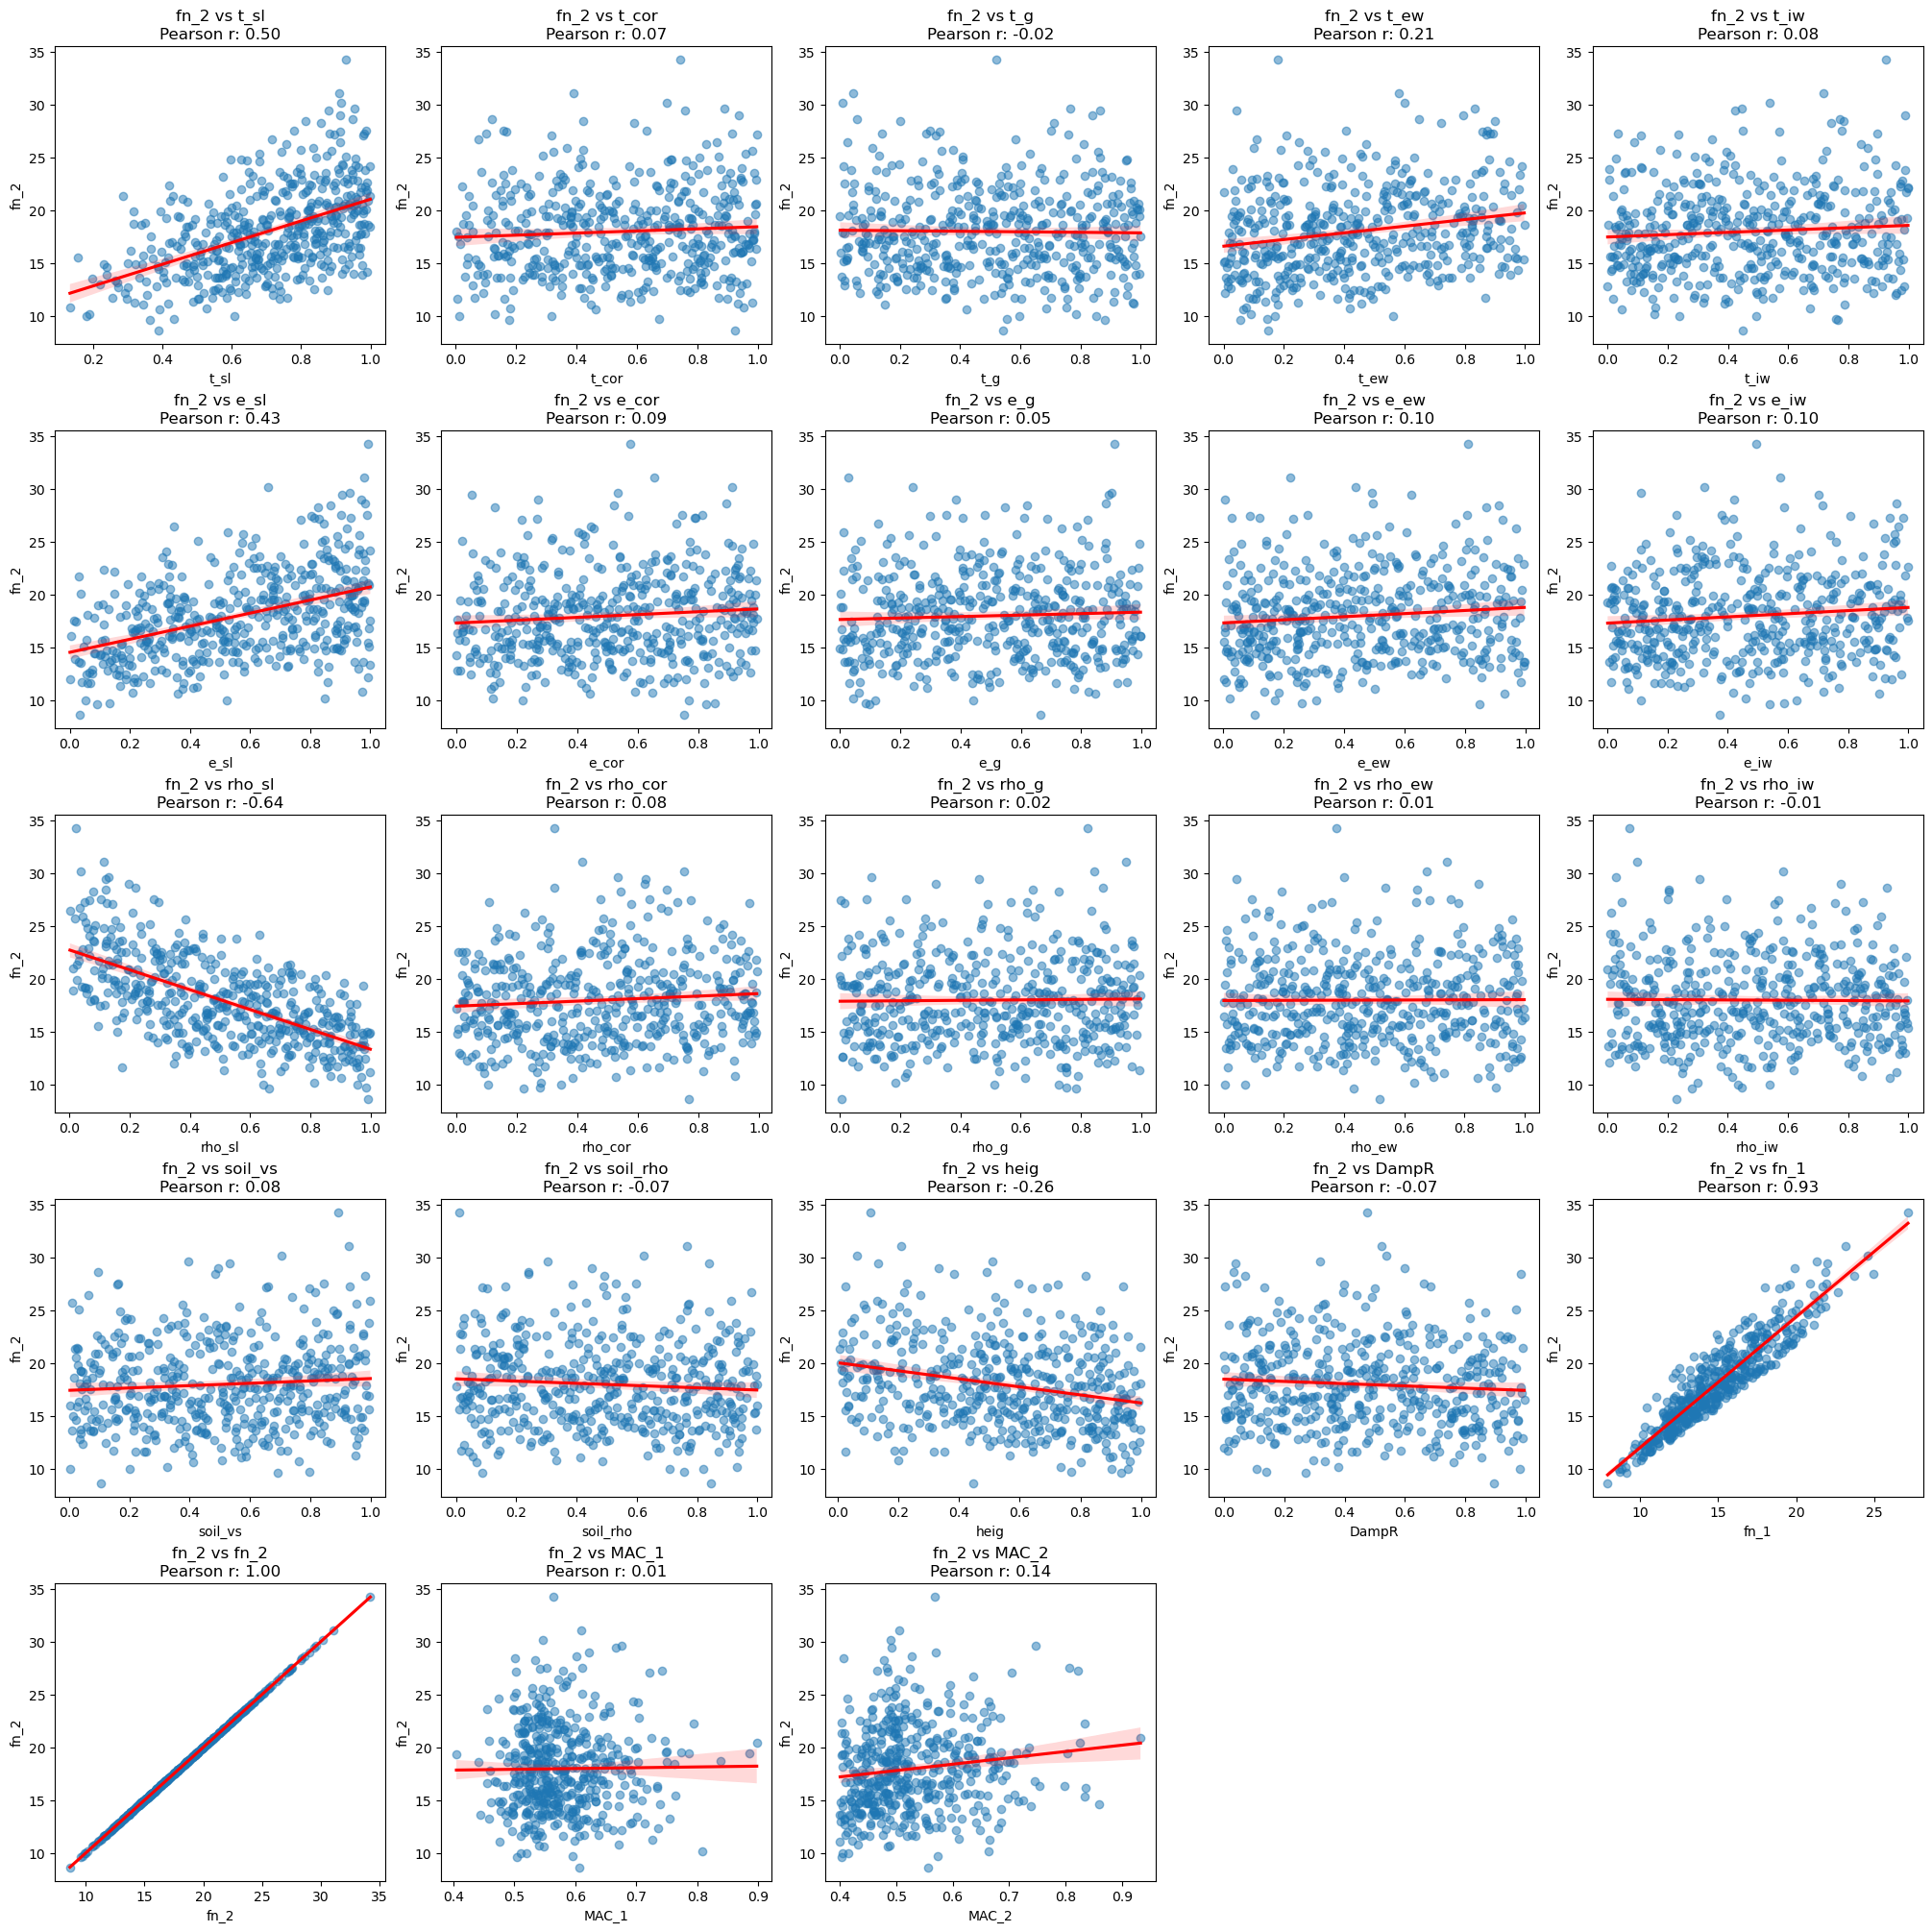

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

data_type = 'fn_2'
num_inputs = 24
num_cols = 5  # Number of plots per row
num_rows = (num_inputs + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, input_col in enumerate(data.columns[:-1]):  # Exclude 'MAC'
    # Compute Pearson correlation
    result= linregress(data[input_col], data[data_type])
    corr = result.rvalue

    # Plot with regression line
    sns.regplot(
        x=input_col, y=data_type, data=data,
        ax=axes[i], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5}
    )
    axes[i].set_title(f"{data_type} vs {input_col}\nPearson r: {corr:.2f}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


### Splitting the data for train and test

In [104]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr

print(np.shape(valid_X))
print(np.shape(X))
inputs = valid_X
outputs = valid_Y2
outputs_fn1 = valid_Y2
outputs_fn2 = valid_Y3
outputs_fn3 = valid_Y4
outputs_fn4 = valid_Y5

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=7)
X_train_fn1, X_test_fn1, y_train_fn1, y_test_fn1 = train_test_split(inputs, outputs_fn1, test_size=0.1, random_state=7)
X_train_fn2, X_test_fn2, y_train_fn2, y_test_fn2 = train_test_split(inputs, outputs_fn2, test_size=0.1, random_state=7)
X_train_fn3, X_test_fn3, y_train_fn3, y_test_fn3 = train_test_split(inputs, outputs_fn3, test_size=0.1, random_state=7)
X_train_fn4, X_test_fn4, y_train_fn4, y_test_fn4 = train_test_split(inputs, outputs_fn4, test_size=0.1, random_state=7)

# Initialize PCA
pca = PCA(n_components=10)  # Choose the number of components (e.g., 10)

# Fit PCA on training inputs and transform both training and test sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")

# Compute Pearson and Spearman correlations for each feature
correlations = []
for i in range(inputs.shape[1]):
    pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
    spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
    correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))

# Display results in a DataFrame
df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
print(df)


(499, 19)
(1000, 19)
Explained variance by PCA components: [0.07559566 0.07276418 0.06681396 0.06399219 0.06250428 0.06068241
 0.05770103 0.05722121 0.05468589 0.05333762]
       Feature  Pearson Corr  Spearman Corr
0    Feature 1     -0.223626      -0.225450
1    Feature 2      0.037427       0.036639
2    Feature 3      0.038104       0.036831
3    Feature 4      0.021345       0.023481
4    Feature 5     -0.210679      -0.204130
5    Feature 6      0.053534       0.060456
6    Feature 7      0.158635       0.174742
7    Feature 8      0.235052       0.261176
8    Feature 9      0.018199       0.004178
9   Feature 10      0.039226      -0.006675
10  Feature 11     -0.088300      -0.066891
11  Feature 12     -0.102037      -0.112893
12  Feature 13     -0.072410      -0.051429
13  Feature 14      0.096006       0.068043
14  Feature 15      0.271276       0.272989
15  Feature 16      0.085654       0.098776
16  Feature 17      0.174526       0.184442
17  Feature 18     -0.040480      -0

### Building the surrogate model using GPR with PCA for dimension reduction

R² Score: 0.3844614258438199
NMSE: 0.6155385741561801


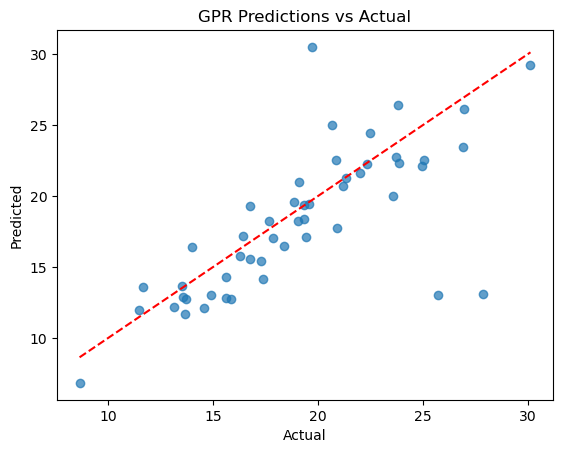

In [105]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

X_train = X_train_fn2
y_train = y_train_fn2
X_test  = X_test_fn2
y_test  = y_test_fn2
# Initialize and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train, y_train)

# Predict on the test set
y_pred = gpr.predict(X_test)

# Compute R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Compute NMSE (Normalized Mean Squared Error)
nmse = mean_squared_error(y_test, y_pred) / np.var(y_test)
print(f"NMSE: {nmse}")


plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual")
plt.show()


### Visualization of the surrogate model

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the indices of the two variables you want to vary
var1_index = 2  # Index for the 5th variable (Python is zero-indexed)
var2_index = 1  # Index for the 10th variable

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Select the desired variables from X_test
var1 = X_test[:, var1_index]
var2 = X_test[:, var2_index]

# Calculate the mean of the remaining 17 variables
mean_vars = np.mean(X_test, axis=0)


# Generate a grid of values for var1 and var2 (these will vary, others are fixed)
var1_grid, var2_grid = np.meshgrid(np.linspace(var1.min(), var1.max(), 50),
                                   np.linspace(var2.min(), var2.max(), 50))

# Flatten the grids for var1 and var2 to create 1D arrays
var1_flat = var1_grid.ravel()
var2_flat = var2_grid.ravel()

# Create a new input matrix for predictions
# Stack the selected variables and tile the other variables' mean values
X_grid = np.column_stack([  np.tile(mean_vars, (len(var1_flat), 1))])
X_grid[:,var1_index] = var1_flat
X_grid[:,var2_index] = var2_flat
# Generate predictions for the grid (assuming gpr is your trained model)
y_pred_grid = gpr.predict(X_grid).reshape(var1_grid.shape)

# Now, y_pred_grid has shape (50, 50), matching the grid's shape

# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot

surf = ax.plot_surface(var1_grid, var2_grid, y_pred_grid, cmap='viridis', alpha=0.8)
#ax.scatter(var1, var2, y_test, c='red', label='Test Results', s=50)

# Add labels and title
ax.set_xlabel(f'X{var1_index + 1}: {input_name[var1_index]}')
ax.set_ylabel(f'X{var2_index + 1}: {input_name[var2_index]}')
ax.set_zlabel('Predicted Y')

ax.set_title('3D Surface Plot of Predicted Y vs Two Variables')
# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()




### Build the surrogate model for two natural frequencies

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1.fit(X_train_fn1, y_train_fn1)
# Predict on the test set
y_pred_fn1 = gpr_fn1.predict(X_test_fn1)


# Initialize and train the GPR model
gpr_fn2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2.fit(X_train_fn2, y_train_fn2)
# Predict on the test set
y_pred_fn2 = gpr_fn2.predict(X_test_fn2)


# Initialize and train the GPR model
gpr_fn3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn3.fit(X_train_fn3, y_train_fn3)
# Predict on the test set
y_pred_fn3 = gpr_fn3.predict(X_test_fn3)


# Initialize and train the GPR model
gpr_fn4 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn4.fit(X_train_fn4, y_train_fn4)
# Predict on the test set
y_pred_fn4 = gpr_fn4.predict(X_test_fn4)

print(f"gpr_fn1 performace: R² Score: {r2_score(y_test_fn1, y_pred_fn1)}, NMSE: {mean_squared_error(y_test_fn1, y_pred_fn1) / np.var(y_test_fn1)}")
print(f"gpr_fn2 performace: R² Score: {r2_score(y_test_fn2, y_pred_fn2)}, NMSE: {mean_squared_error(y_test_fn2, y_pred_fn2) / np.var(y_test_fn2)}")
print(f"gpr_MAC1 performace: R² Score: {r2_score(y_test_fn3, y_pred_fn3)}, NMSE: {mean_squared_error(y_test_fn3, y_pred_fn3) / np.var(y_test_fn3)}")
print(f"gpr_MAC2 performace: R² Score: {r2_score(y_test_fn4, y_pred_fn4)}, NMSE: {mean_squared_error(y_test_fn4, y_pred_fn4) / np.var(y_test_fn4)}")


gpr_fn1 performace: R² Score: 0.9725054172055485, NMSE: 0.027494582794451453
gpr_fn2 performace: R² Score: 0.9699973550246174, NMSE: 0.030002644975382624
gpr_MAC1 performace: R² Score: -0.14180075105944967, NMSE: 1.1418007510594494
gpr_MAC2 performace: R² Score: 0.16055720988759903, NMSE: 0.839442790112401


### Using L-BFGS-B for FEM update

In [10]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred = surrogate_fn1(x)
    fn2_pred = surrogate_fn2(x)
    return (10*(fn1_pred - 12.1344))**2 + (100*(fn2_pred - 18.8672))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)

# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.48, 0.52) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[17] = (0.45,0.55)
bounds[18] = (0,0.7)
# Initial guess for the parameters
x0 = np.random.uniform(0.5, 0.5 ,size=19)





# Perform optimization
result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

# Optimized parameters
if result.success:
    optimized_params = result.x
    print("Optimized Parameters:", optimized_params)
    print("Objective Function Value:", result.fun)
    print(f"fn_1: {surrogate_fn1(result.x)}, fn_2: {surrogate_fn2(result.x)}")
else:
    print("Optimization failed:", result.message)




Optimized Parameters: [1.         0.52       0.48       0.21057363 0.48       0.6900927
 0.51987426 0.51880441 0.20294117 0.21044228 0.8252546  0.52
 0.48021162 0.49128988 0.48062816 0.48056845 0.51907621 0.55
 0.45714265]
Objective Function Value: 1.3001016475380915e-09
fn_1: 12.134403580957951, fn_2: 18.867199957838807


### FEM update

In [11]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

# Transform X from [0,1] to [-1,1]
X_transformed = 2 * result.x - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

print(np.shape(X_transformed))

    
simu_tk.mapdl.clear()

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
#
simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
#
#
# Excitation point: Hammer 2.0 Pos1 (shaker)
tol = 0.3
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
#
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
print(nsel_id_2)
simu_tk.mapdl.nsel('ALL')
#
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
print(nsel_id_3)
simu_tk.mapdl.nsel('ALL')
#
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=0.4, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[0])
#
#
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
#
#
## Get FRF at target point
meas_FRFs = simu_tk.get_FRFs_meas_EXAMPLE()
#
#
DOE_info = {
    'id':i_doe,
    'X':result.x.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs
    }

simu_tk.mapdl.clear()
#clear_output(wait=True)

print(DOE_info['t_info'])
print(DOE_info['e_info'])
print(DOE_info['r_info'])
print(DOE_info['s_info'])
print(DOE_info['height'])
print(DOE_info['dr'])

(1, 19)
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.5385000000000004
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 8.0011 seconds.
[3707 3708]
[4146 4147]
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  0.4
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04414285293003866
     Excitation node               :  4146
Using Modal-superpostion method
     /SOLU finished, duration 48.4483 seconds.
 Extract all modal informati

12.2275605 18.925003 0.8595236069468907 0.6535937830680514


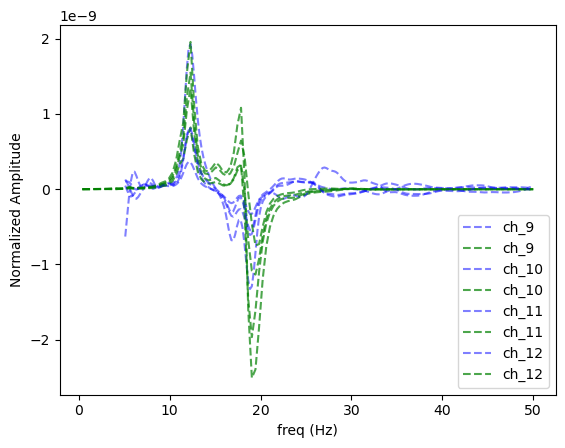

In [15]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]

loaded_data = DOE_info
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )




i_file = 9
#i_pos = 3
i_pos_2OG = [3,13,14,15]
i_pos_1OG = [9,10,11,12]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs[f'disp_ch{i_ch_disp[i]}']['freq'], meas_FRFs[f'disp_ch{i_ch_disp[i]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()






[12.2275605 12.2275605 12.2275605 12.2275605 12.2275605 12.2275605
 12.2275605 12.2275605]
[18.925003 18.925003 18.925003 18.925003 18.925003 18.925003 18.925003
 18.925003]
[0.85952361 0.85952361 0.85952361 0.85952361 0.85952361 0.85952361
 0.85952361 0.85952361]
[0.65359378 0.65359378 0.65359378 0.65359378 0.65359378 0.65359378
 0.65359378 0.65359378]
12.2275605 18.925003 0.8595236069468907 0.6535937830680514


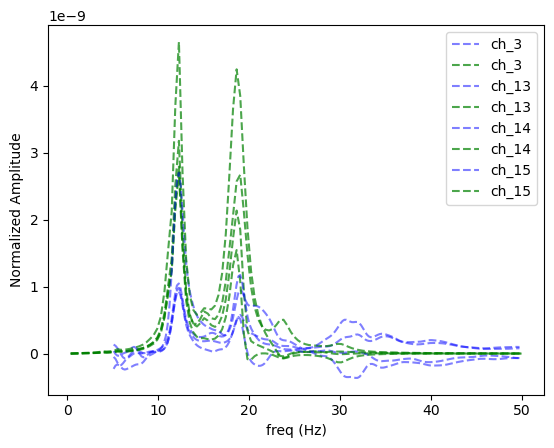

In [13]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]

loaded_data = DOE_info
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)

print(mode_freq_1_list)
print(mode_freq_2_list)
print(mac_1_list)
print(mac_2_list)
print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )




i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
#i_pos_1OG = [9,10,11,12]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs[f'disp_ch{i_ch_disp[i+4]}']['freq'], meas_FRFs[f'disp_ch{i_ch_disp[i+4]}']['imag'], label=f"ch_{i_pos}",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

